In [46]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from sklift.metrics.metrics import qini_auc_score
from sklift.viz import plot_qini_curve


In [67]:
# Function for calculating uplift score and building qini curve
def qini_df(df, uplift_score='uplift_score'):
    # Ranking the sample by uplift value in descending order
    ranked = df.sort_values(uplift_score, ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Calculating main values for qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Qini curve
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Random curve
    ranked['random_uplift'] = round(ranked[uplift_score].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked[uplift_score].rank(pct=True, ascending=False)
    # Visualization
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

In [4]:
df = pd.read_csv('criteo-uplift-v2.1.csv')
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [5]:
df['treatment'].value_counts()

1    11882655
0     2096937
Name: treatment, dtype: int64

In [6]:
df['conversion'].value_counts()

0    13938818
1       40774
Name: conversion, dtype: int64

##### Target Class Declaration
Control Non-Responders(CN) - no treatment and no response (value = 0)   
Control Responders(CR) - no treatment and respond (value = 1)   
Treatment Non-Responders(TN) - treatment and no response (value = 2)   
Treatment Responders(TR) - treatment and response (value = 3)

In [7]:
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df['treatment'] == 0) & (df['conversion'] != 0),'target_class'] = 1 
    #TN:
    df.loc[(df['treatment'] != 0) & (df['conversion'] == 0),'target_class'] = 2 
    #TR:
    df.loc[(df['treatment'] != 0) & (df['conversion'] != 0),'target_class'] = 3 
    return df

In [8]:
df = declare_tc(df)
df['target_class'].value_counts()

2    11845944
0     2092874
3       36711
1        4063
Name: target_class, dtype: int64

#### Validation Dataset

In [9]:
feature_col = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
              'f9', 'f10', 'f11']
target = 'conversion'
treatment = 'treatment'

In [19]:
# We will use only part of the dataset, which is dictated by the available calculating capacity 
large, small = train_test_split(df, stratify=df[[treatment, target]], random_state=42, test_size=0.05)

In [20]:
small['target_class'].value_counts()

2    592297
0    104644
3      1836
1       203
Name: target_class, dtype: int64

In [21]:
df_train, df_test = train_test_split(small, stratify=small[[treatment, target]], random_state=42, test_size=0.3)

In [22]:
df_test['target_class'].value_counts()

2    177689
0     31393
3       551
1        61
Name: target_class, dtype: int64

#### S-learner

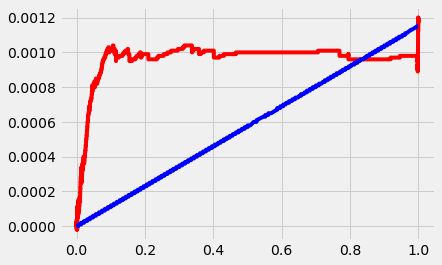

80.72577999999999

In [28]:
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=42, 
                                                       verbose=0))

s_learner.fit(X=df_train[feature_col],
              treatment=df_train[treatment],
              y=df_train[target])

uplift_vals = s_learner.predict(np.array(df_test[feature_col].values.copy()))

df_test['uplift_score_S'] = uplift_vals
score_S = qini_df(df_test, 'uplift_score_S')
score_S

In [51]:
qini_S = qini_auc_score(df_test[target], df_test['uplift_score_S'], df_test[treatment], negative_effect=True)
qini_S

0.13508245077433348

#### T-learner

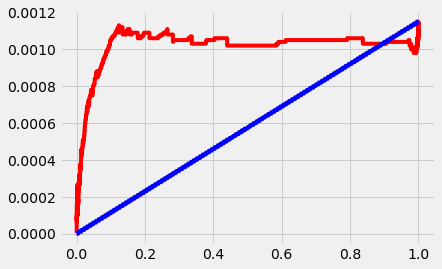

92.66563000000001

In [27]:
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=42, 
                                                       verbose=0))

t_learner.fit(X=df_train[feature_col],
              treatment=df_train[treatment],
              y=df_train[target])

uplift_vals = t_learner.predict(np.array(df_test[feature_col].values.copy()))

df_test['uplift_score_T'] = uplift_vals
score_T = qini_df(df_test, 'uplift_score_T')
score_T

In [52]:
qini_T = qini_auc_score(df_test[target], df_test['uplift_score_T'], df_test[treatment], negative_effect=True)
qini_T

0.1589986868874217

#### X-learner

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

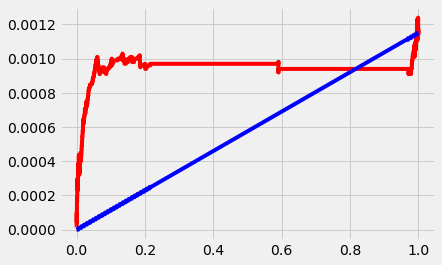

75.20616999999999

In [26]:
x_learner = BaseXClassifier(outcome_learner=RandomForestClassifier(),
                            effect_learner=RandomForestRegressor())

x_learner.fit(X=df_train[feature_col],
              treatment=df_train[treatment],
              y=df_train[target])

uplift_vals = x_learner.predict(np.array(df_test[feature_col].values.copy()))

df_test['uplift_score_X'] = uplift_vals
score_X = qini_df(df_test, 'uplift_score_X')
score_X

In [57]:
qini_X = qini_auc_score(df_test[target], df_test['uplift_score_X'], df_test[treatment], negative_effect=True)
qini_X

0.12663622485497847

#### R-learner

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

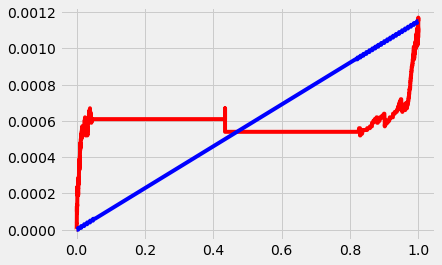

9.917039999999993

In [25]:
r_learner = BaseRClassifier(outcome_learner=RandomForestClassifier(),
                            effect_learner=RandomForestRegressor())

r_learner.fit(X=df_train[feature_col],
              treatment=df_train[treatment],
              y=df_train[target])

uplift_vals = r_learner.predict(np.array(df_test[feature_col].values.copy()))

df_test['uplift_score_R'] = uplift_vals
score_R = qini_df(df_test, 'uplift_score_R')
score_R

In [53]:
qini_R = qini_auc_score(df_test[target], df_test['uplift_score_R'], df_test[treatment], negative_effect=True)
qini_R

-0.008815916228812913

#### UpliftRandomForest

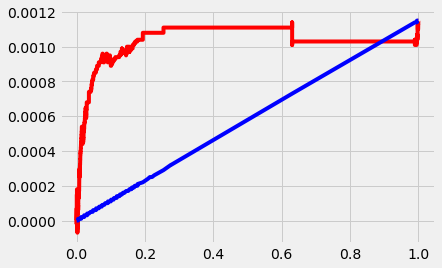

92.80319000000003

In [23]:
uplift_model = UpliftRandomForestClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(df_train[feature_col].values,
                 treatment=df_train[treatment].apply(str).values,
                 y=df_train[target].values)

uplift_vals = uplift_model.predict(np.array(df_test[feature_col].values.copy()))

df_test['uplift_score_randF'] = uplift_vals
score_randF = qini_df(df_test, 'uplift_score_randF')
score_randF

In [54]:
qini_randF = qini_auc_score(df_test[target], df_test['uplift_score_randF'], df_test[treatment], negative_effect=True)
qini_randF

0.16159652993643622

### Conclusion

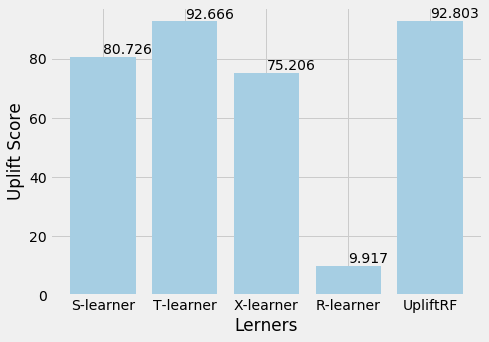

In [59]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
learners = ['S-learner', 'T-learner', 'X-learner', 'R-learner', 'UpliftRF']
scores = [score_S, score_T, score_X, score_R, score_randF]
ax.bar(learners,scores)
for index,data in enumerate(scores):
    plt.text(x=index , y =data+1 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=14))
ax.set_xlabel('Lerners')
ax.set_ylabel('Uplift Score')
plt.show()

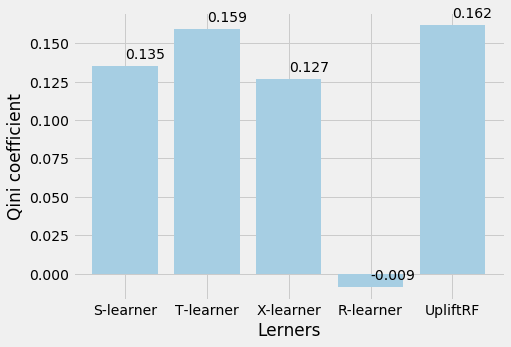

In [66]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
learners = ['S-learner', 'T-learner', 'X-learner', 'R-learner', 'UpliftRF']
scores = [qini_S, qini_T, qini_X, qini_R, qini_randF]
ax.bar(learners,scores)
for index,data in enumerate(scores):
    plt.text(x=index , y=data+0.005 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=14))
ax.set_xlabel('Lerners')
ax.set_ylabel('Qini coefficient')
plt.show()

All models, except R-learner, showed relatively close qini coefficients with UpliftRandomForest as the best one, and T-learner as the second best with qini coefficient lagging behind by 0.003 units.

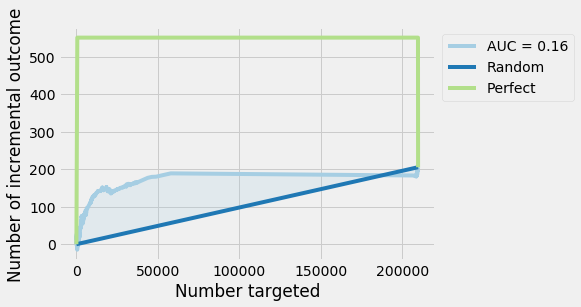

In [50]:
plot_qini_curve(df_test[target], df_test['uplift_score_randF'],df_test[treatment], perfect=True)